In [2]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set() 
import jax
import jax.numpy as jnp
from jax.example_libraries.optimizers import adam
from jax.example_libraries import stax

## PCA

Read data

In [20]:
df = pd.read_parquet('./data_IDS2017/combined.parquet')
df = df.drop(columns=['Label'])
display(df)

,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Mean,Bwd Packet Length Mean,Fwd IAT Total,Bwd Packets/s,Average Packet Size,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,Idle Mean
0,2,12,6.00000,0.0,4,0.000000,9.00000,329,-1,1,0.0
1,2,12,6.00000,0.0,1,0.000000,9.00000,329,-1,1,0.0
2,2,12,6.00000,0.0,3,0.000000,9.00000,245,-1,1,0.0
3,2,12,6.00000,0.0,1,0.000000,9.00000,245,-1,1,0.0
4,7,484,69.14286,103.5,609,6568.144500,81.63636,8192,2053,5,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2202988,2,82,41.00000,164.0,3,3.416047,112.75000,-1,-1,1,0.0
2202989,2,94,47.00000,110.0,1,10416.667000,90.25000,-1,-1,1,0.0
2202990,2,94,47.00000,175.0,48,4494.382000,122.75000,-1,-1,1,0.0
2202991,1,0,0.00000,0.0,0,9090.909000,0.00000,64,256,0,0.0


In [22]:
x = df.to_numpy()
col_mean = np.nanmean(x, axis=0)
inds = np.where(np.isnan(x))
x[inds] = np.take(col_mean, inds[1])
m = np.mean(x, 0)
s = np.std(x, 0)
x = (x-m)/s

In [23]:
u,s,vh = np.linalg.svd(x,full_matrices=False)
fi = vh.T
z = u@np.diag(s)

<Axes: xlabel='0', ylabel='1'>

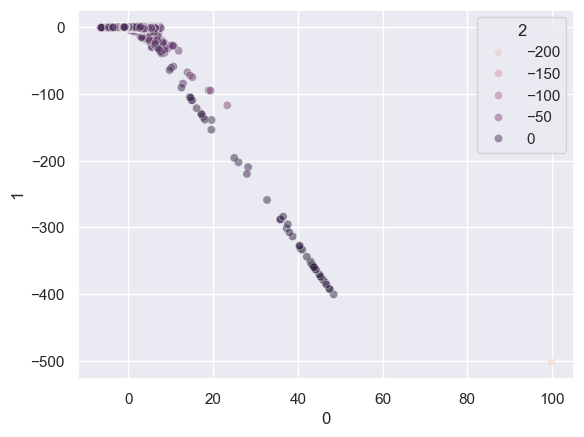

In [24]:
sns.scatterplot(
    data= pd.DataFrame(z),
    x=0,
    y=1,
    hue=2,
    alpha=0.5
)

## Autoencoder

In [31]:
x = df.to_numpy()  

def vector_mse(y,yhat):
    return jnp.mean(jnp.square(y-yhat), axis=-1)

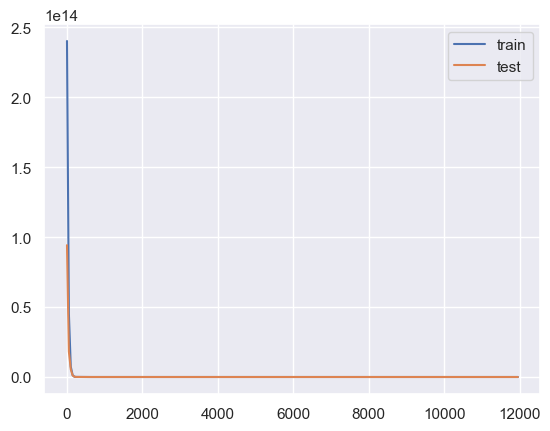

In [32]:
batch_size = 512
steps = 12000 
learning_rate = 0.001
train_split = int(0.7*x.shape[0])

k = jax.random.PRNGKey(42)

encoder = stax.serial(
    stax.Dense(16),
    stax.Relu,
    stax.Dense(16)
)

decoder = stax.serial(
    stax.Dense(16),
    stax.Relu,
    stax.Dense(x.shape[1])
)

nn = stax.serial(encoder, decoder)

init_nn, apply_nn = nn
opt_init, opt_update, get_params = adam(learning_rate)



@jax.jit 
def step(i, opt_state, x,y):
  params = get_params(opt_state)

  def loss(params,x,y):
      reconstruction = apply_nn(params,x) 
      return jnp.mean(vector_mse(y,reconstruction))

  g = jax.grad(loss)(params, x,y) 
  opt_state = opt_update(i, g, opt_state)
  step_loss = loss(get_params(opt_state),x,y)
  return opt_state, step_loss

@jax.jit
def test_loss(opt_state,x,y):
    params = get_params(opt_state) 
    reconstruction = apply_nn(params,x) 
    return jnp.mean(vector_mse(y,reconstruction))

_,params  = init_nn(k,(batch_size,x.shape[1])) 
opt_state = opt_init(params)

losses = []
test_losses = []
train_steps = []

for i in range(steps):
    idx = np.random.randint(0, train_split, size=batch_size)
    bx = x[idx,...]

    opt_state, step_loss = step(i, opt_state,bx,bx) 

    if i % 50 == 0:
        tx = x[train_split:,...]
        test_losses.append(test_loss(opt_state,tx,tx))
        train_steps.append(i) 
        losses.append(test_loss(opt_state,x[:train_split,...],x[:train_split,...]))

plt.plot(train_steps,losses,label='train')
plt.plot(train_steps,test_losses,label='test')
 
plt.legend()